
# Predicting Bankruptcy in the mining industry with Altman's Z-score and the Calcbench API

Edward Altman's Z-score is a formula for predicting corporate bankruptcy.  Below we plot the change in industry aggregate Z-scores for mining companies.  A Z-score above 2.99 is considered "safe", between 1.81 and 2.99 is a "gray" zone, below 1.81 is the "distress" zone.  The troubles in the coal and metal mining industry are clearly illustrated.

[Altman's Z-score @ Wikipedia](https://en.wikipedia.org/wiki/Altman_Z-score)

To replicate the below [sign up for a Calcbench account](https://www.calcbench.com/join), install the Calcbench Python API client from [here](https://github.com/calcbench/python_api_client) and download this note book from [github](https://github.com/calcbench/notebooks/blob/master/z-score.ipynb).

In [ ]:
%pip install "calcbench-api-client[Pandas]" tqdm

In [11]:
import calcbench as cb
import pandas as pd
from tqdm import tqdm
from calcbench.api_query_params import PeriodType, Revisions

pd.options.display.max_rows = 1000

In [4]:
cb.api_client._rig_for_testing("localhost")

In [5]:
z_score_metrics = [
    "CurrentAssets",
    "CurrentLiabilities",
    "Assets",
    "RetainedEarnings",
    "EBIT",
    "MarketCapAtEndOfPeriod",
    "Liabilities",
    "Revenue",
]

In [6]:
SIC_codes = {
    "Oil And Gas Extraction": 1300,
    "Metal Mining": 1000,
    "Coal Mining": 1200,
    "Mining Nonmetallic Minerals": 1400,
}

In [18]:
def peer_group_z_score(peer_group):
    peer_group = peer_group[
        (peer_group.ticker != "GMC") & (peer_group.ticker != "PPI")
    ]  # GMC's marketvalue is off

    z_score_data = cb.standardized(
        company_identifiers=list(peer_group.ticker),
        metrics=z_score_metrics,
        period_type=PeriodType.Annual,
        revisions=Revisions.MostRecent,
    )
    aggregate_data = z_score_data.unstack('metric')['value'].groupby(level='fiscal_period').sum()
    return compute_z_score(aggregate_data), z_score_data

In [17]:
def compute_z_score(inputs: pd.DataFrame):
    working_capital = inputs["CurrentAssets"] - inputs["CurrentLiabilities"]

    z_score = (
        1.2 * (working_capital / inputs["Assets"])
        + 1.4 * (inputs["RetainedEarnings"] / inputs["Assets"])
        + 3.3 * (inputs["EBIT"] / inputs["Assets"])
        + 0.6 * (inputs["MarketCapAtEndOfPeriod"] / inputs["Liabilities"])
        + 0.99 * (inputs["Revenue"] / inputs["Assets"])
    )

    return z_score

In [9]:
peer_groups = [
    (industry, cb.companies(SIC_codes=[SIC_code]))
    for industry, SIC_code in SIC_codes.items()
]
sp500 = cb.companies(index="SP500")
sp500_no_financials = sp500[
    sp500.sic_code & ((sp500.sic_code < 6000) | (sp500.sic_code >= 7000))
]  # There is a different z-score formulas for financials.
peer_groups.append(("SP500 (no financials)", sp500_no_financials))

In [12]:
sp500 = cb.companies(index="SP500")
sp500_no_financials = sp500[
    sp500.sic_code & ((sp500.sic_code < 6000) | (sp500.sic_code >= 7000))
]  # There is a different z-score formulas for financials.
peer_groups.append(("SP500 (no financials)", sp500_no_financials))

In [19]:
industry_z_scores = [
    (industry, peer_group_z_score(peer_group)[0])
    for industry, peer_group in tqdm(peer_groups)
]
z_scores = pd.DataFrame.from_dict(dict(industry_z_scores))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [06:04<00:00, 60.73s/it]


AttributeError: type object 'DataFrame' has no attribute 'from_items'

In [26]:
z_scores = pd.DataFrame.from_dict(dict(industry_z_scores))

  0%|                                                                                         | 0/6 [17:37:26<?, ?it/s]


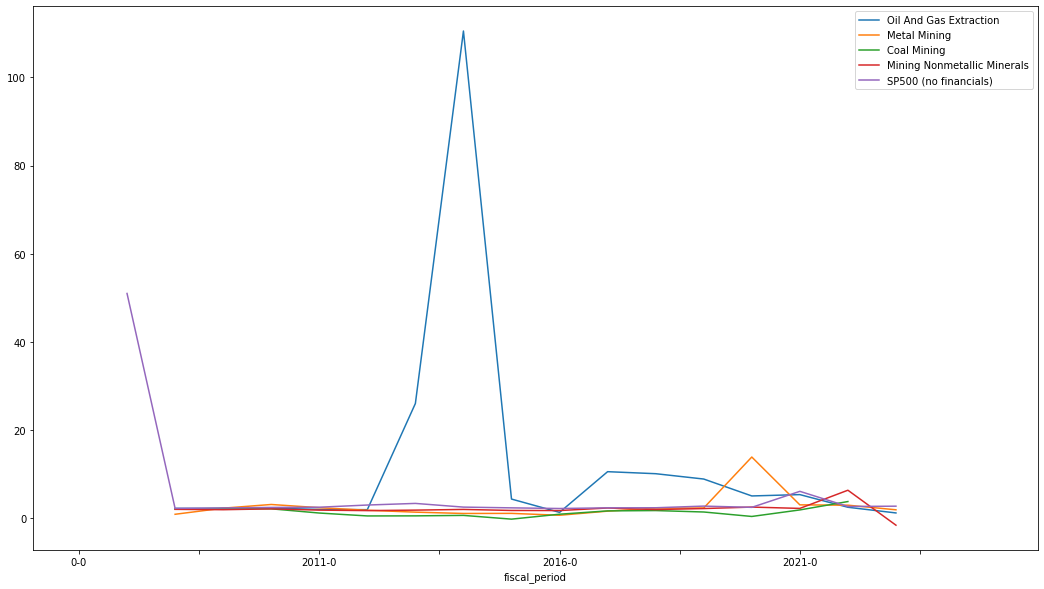

In [27]:
z_scores.plot(figsize=(18, 10))